In [60]:
import numpy as np
import pandas as pd
import os
from os.path import join
import glob
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'

train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)

test_image_paths = [glob.glob(join(TEST_PATH, test_id, "images", "*"))[0] for test_id in test_ids]
train_image_paths = [glob.glob(join(TRAIN_PATH, train_id, "images", "*"))[0] for train_id in train_ids]

train_masks_paths = [glob.glob(join(TRAIN_PATH, train_id, "masks", "*")) for train_id in train_ids]
print("Number of training images: ", len(train_image_paths), "\tNumber of testing images: ",len(test_image_paths))
print(len(train_masks_paths[1]))
print(train_image_paths[10], train_masks_paths[10][1])

Number of training images:  670 	Number of testing images:  65
92
../input/stage1_train/57d88f45e479ce3821839b2706d667758c63ac769d76800d815c73d2507c1e42/images/57d88f45e479ce3821839b2706d667758c63ac769d76800d815c73d2507c1e42.png ../input/stage1_train/57d88f45e479ce3821839b2706d667758c63ac769d76800d815c73d2507c1e42/masks/534580d4deca86bd7191f09918cd8972901d0cdffc28d5886de3c267d76e6b65.png


RGB to gray

Image ID:  f6863b83d75e5927b30e2e326405b588293283c25aaef2251b30c343296b9cb1
Original image size:  (256, 256)


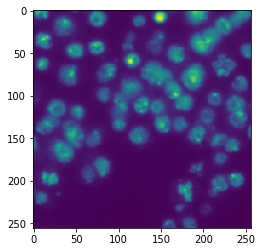

In [66]:
image_select = 1
tmp_image_path = train_image_paths[image_select]
tmp_image = cv2.imread(tmp_image_path, cv2.IMREAD_GRAYSCALE)

print("Image ID: ", train_ids[image_select])
plt.imshow(tmp_image)

# Print the image dimensions
print("Original image size: ", tmp_image.shape)

Combine all the masks in one image.


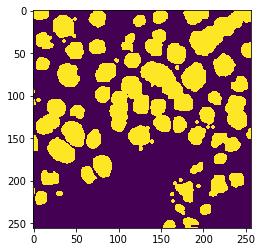

In [68]:
# combine all masks
maskall = np.zeros(tmp_image.shape)
for mask_path in train_masks_paths[image_select]:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    maskall += mask
maskall = np.where(maskall > 1, 255, 0)
print("Combine all the masks in one image.")
plt.imshow(maskall)

Remove background
Assume two class in the image: object of interest and background. The expected data distribution is a bimodal distribution. 
Mean, medium could be options.
The OSTU method is useful because it models the image as a bimodal distribution and finds the optimal separation value.
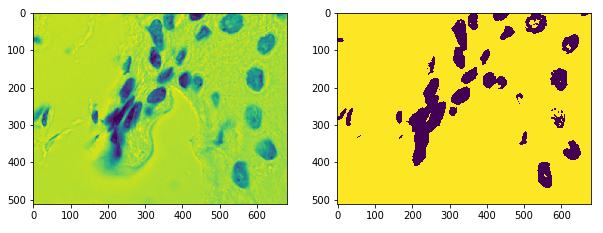
Note: the threshold method sometimes lose information

In [ ]:
# threshold
ret, thresh = cv2.threshold(tmp_image, 100, 255, cv2.THRESH_OTSU)

fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(tmp_image)
axs[1].imshow(thresh)
    

In [ ]:
# deriving individual masks for each object
from scipy import ndimage
labels, nlabels = ndimage.label(thresh)

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

In [ ]:
# find contour
_, cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
# cnts is a list of contours

In [ ]:
max_cnt_area = cv2.contourArea(cnts[0])
print("The area of the largest object is: {0}".format(max_cnt_area))

In [ ]:
# invert
if max_cnt_area > 50000:
    ret, thresh = cv2.threshold(tmp_image, 100, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

### Morphological Transformations
Closing, Erode, Dilation

In [ ]:
#define kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))

# closing = dilation + erode
mask = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# dilate and erode
#mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5)))
#mask = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)))

fig, axs = plt.subplots(1, 4, figsize=(30,30))
axs[0].imshow(tmp_image)
axs[1].imshow(thresh)
axs[2].imshow(mask)
axs[3].imshow(cv2.bitwise_and(tmp_image, tmp_image, mask=mask))

In [ ]:
cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

### Process the image for submission

In [ ]:
# define functions for threshold and morphological transformation
def threshold(image_gray):
    image_gray = cv2.GaussianBlur(image_gray, (7, 7), 1)
    ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_OTSU)
    
    _, cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    max_cnt_area = cv2.contourArea(cnts[0])
    
    if max_cnt_area > 50000:
        ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    
    return thresh

def apply_morphology(thresh):
    mask = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
    return mask

In [ ]:
segmented = []
for test_image_path in test_image_paths:
    tmp_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    
    thresh = threshold(tmp_image)
    mask = apply_morphology(thresh)
    
    segmented.append(mask)

In [ ]:
# Run length Encoding from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python

from skimage.morphology import label

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [ ]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(segmented[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [ ]:
submission_df = pd.DataFrame()
submission_df['ImageId'] = new_test_ids
submission_df['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

In [ ]:
print (submission_df.shape)

In [ ]:
# check length of submission
if not len(np.unique(submission_df["ImageId"])) == len(test_ids):
    print("Submission is not complete")
    print("Missing test ids: {0}".format(set(test_ids).difference(set(np.unique(submission_df["ImageId"])))))
else:
    print("Submission is complete")

In [ ]:
# convert to csv for submission
submission_df.to_csv('submission_pure_cv.csv', index=False)

In [ ]:
print (mask.shape)
print (segmented[1])
print (mask)